# The basics of Bayesian optimization

Many real-world problems involve optimization of functions which are difficult, or costly, to evaluate. For instance, in deep learning, finding the optimal hyperparameters and architecture of a neural network is a cumbersome process that should ideally be automated with as little fuction evaluations (i.e. training the networks) as possible.

For problems like these, Bayesian optimization (BO) offers a unifying framework where the function to evaluate is approximated using a surrogate model, for instance a Gaussian process. In this notebook, we introduce the basics of BO.

We load some libraries first.

In [1]:
suppressMessages({    
    library(pracma)
    library(rdist)
    library(tidyverse)
    library(colorspace)    
    library(rstan)
    library(bayesplot)
})

set.seed(23)

In [2]:
scatterplot <- function(
    x.true, y.true, f_star=NULL, f_star_var=NULL, data=NULL) {
    df <- data.frame(x=x.true, y=y.true)
   
    g <- ggplot() +       
        theme(axis.line.x = element_line(color="black", size = .25),
              axis.line.y = element_line(color="black", size = .25))

    if (!is.null(f_star) && !is.null(f_star_var)) {
        df_star <- data.frame(
            x=x.true,
            y=f_star, 
            lower=f_star - sqrt(f_star_var), 
            upper=f_star + sqrt(f_star_var))
        g <- g + 
            geom_ribbon(data=df_star, aes(x, ymin = lower, ymax = upper, fill="#DCBCBC")) +             
            geom_line(data=df_star, aes(x, y, color="darkred"))
    }
    if (!is.null(data)) {
        g <- g + geom_point(data=data, aes(x, y, color="darkred")) 
    }
    
    g + 
     geom_line(data=df, aes(x, y, color="darkgrey")) +
     scale_color_manual(
            breaks = c("darkgrey", "darkred", "black"), 
            labels = c("Function to optimize", "Posterior", "Acquisition function"),
            values = c("darkgrey", "darkred", "black")
        ) +
        scale_fill_manual(
            breaks = c("lightgrey", "darkred", "#DCBCBC"),
            values = c("lightgrey", "darkred", "#DCBCBC")
        ) +
    labs(color = "Legend") +
    guides(fill=FALSE)
}

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstration BO on the example function below.

In [3]:
f <- function(x) cos(4 * x) + exp(-(x ** 2) / 2)

Without loss of generality, we constrain the optimization on a set of $n$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code.

In [4]:
n <- 1000

x.init = seq(-5, 5, length.out = n)
y.init = f(x.init)

Below is the function to optimize:

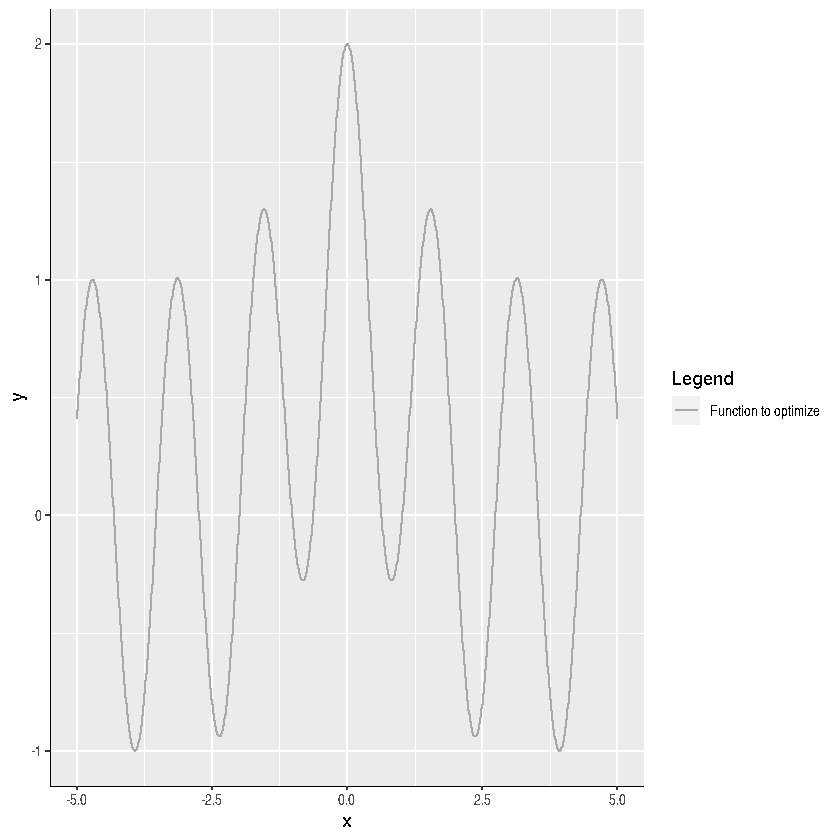

In [5]:
scatterplot(x.init, y.init)

To optimize this function, we define functions to fit a surrogate model and make a predict using the model fit. We use Stan to implement the surrogate model for which we use a Gaussian process.

In [6]:
surrogate.model.file <- "_models/bo-surrogate.stan"
cat(readLines(surrogate.model.file), sep="\n")

data {
	int<lower=1> N;
	real x[N];
	vector[N] y;

	int<lower=1> N_star;
	real x_star[N_star];

	real<lower=0> rho;
	real<lower=0> alpha;
	real<lower=0> sigma;
}

parameters {}

model {}

generated quantities {
	vector[N_star] f_star;
	vector[N_star] f_star_cov;

    {
      matrix[N, N] K =  cov_exp_quad(x, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N));
      matrix[N, N] L_K = cholesky_decompose(K);

      vector[N] L_K_div_y = mdivide_left_tri_low(L_K, y);
      vector[N] K_div_y = mdivide_right_tri_low(L_K_div_y', L_K)';
      
      matrix[N, N_star] k_x_x_star = cov_exp_quad(x, x_star, alpha, rho);
      
     
      matrix[N, N_star] v_pred = mdivide_left_tri_low(L_K, k_x_x_star);
      matrix[N_star, N_star] cov_f2 = cov_exp_quad(x_star, alpha, rho) - v_pred' * v_pred
		+ diag_matrix(rep_vector(1e-10, N_star));

		f_star = (k_x_x_star' * K_div_y);
		f_star_cov = diagonal(cov_f2);
	}

}


In [7]:
gp <- stan_model(file = surrogate.model.file)

In [8]:
predict.gp <- function(gp, x, y, x.star) {
    dat <- list(
        N=length(x),
        x=array(x),
        y=array(y),
        N_star=length(x.star),
        x_star=array(x.star),
        rho=1,
        alpha=1,
        sigma=1
    )
    
    pred <- rstan::sampling(gp, dat, chains=1, algorithm="Fixed_param", iter=1, refresh=-1)

    ext <- rstan::extract(pred)
    f.star <- as.vector(ext$f_star)
    f.star.var <- as.vector(ext$f_star_cov)
    
    
    list(f.star, f.star.var)
}

In [9]:
. <- predict.gp(gp, x.init[1], y.init[1], x.init)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023436 seconds (Sampling)
Chain 1:                0.023436 seconds (Total)
Chain 1: 


As acquisition function we use the upper confidence bound.

In [10]:
acquisition.function <- function(gp, x.d, y.d, x.init, conf) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]
    ucb <- f.star + conf * sqrt(f.star.var)
    ucb
}

Finally, we define a function that proposes the next point to evaluate.

In [11]:
acquire <- function(x.d, y.d, x.init, conf=2.0) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]

    ucb <- acquisition.function(gp, x.d, y.d, x.init, conf)
    x.next <- x.init[which.max(ucb)]
    list(x.next=x.next, ucb=ucb, f.star=f.star, f.star.var=f.star.var)
}    

We start with a random point on the interval defined above and query it against the function that we want to evaluate

In [12]:
set.seed(23)

x.d <- runif(1, -5, 5)
y.d <- f(x.d)

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [13]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.var

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021412 seconds (Sampling)
Chain 1:                0.021412 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.020943 seconds (Sampling)
Chain 1:                0.020943 seconds (Total)
Chain 1: 


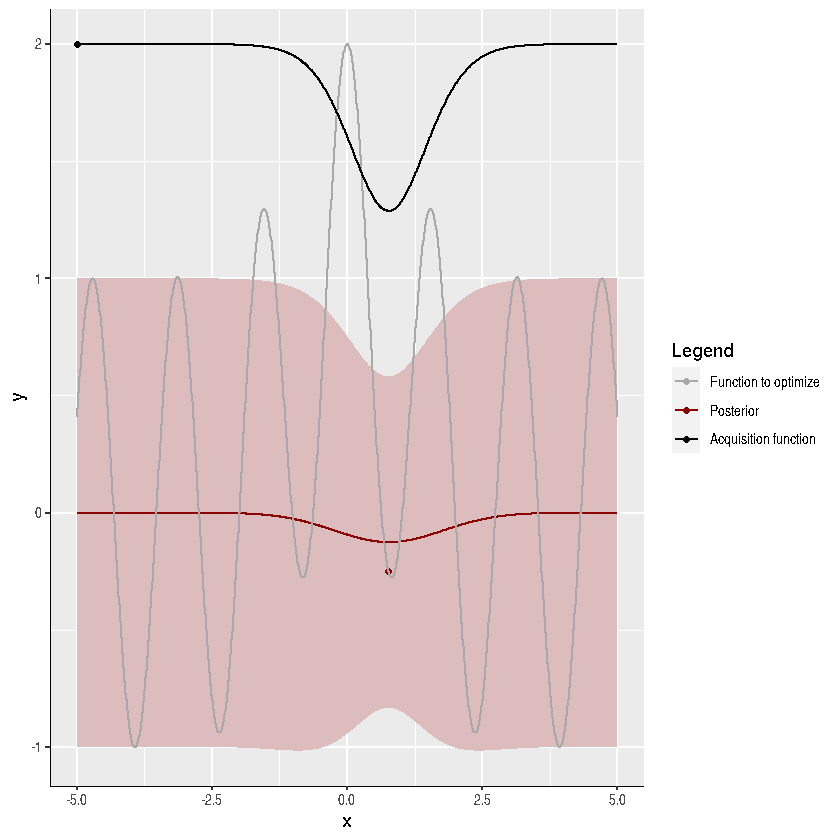

In [14]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [15]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [16]:
iter <- acquire(x.d, y.d, x.init)

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.024137 seconds (Sampling)
Chain 1:                0.024137 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023475 seconds (Sampling)
Chain 1:                0.023475 seconds (Total)
Chain 1: 


In [17]:
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

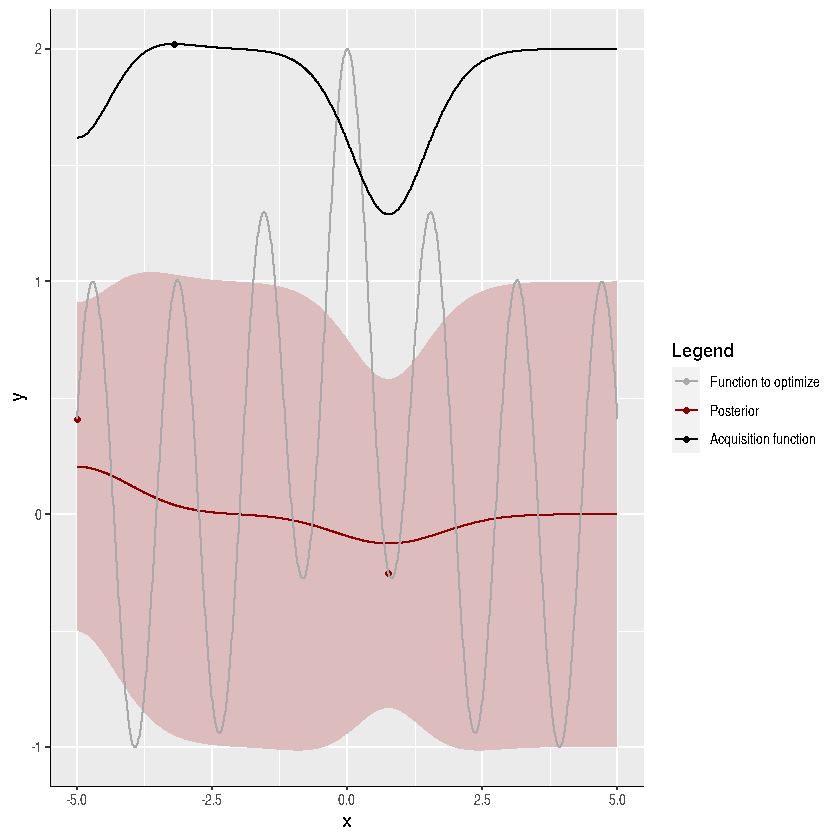

In [18]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [19]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

In [20]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021719 seconds (Sampling)
Chain 1:                0.021719 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021704 seconds (Sampling)
Chain 1:                0.021704 seconds (Total)
Chain 1: 


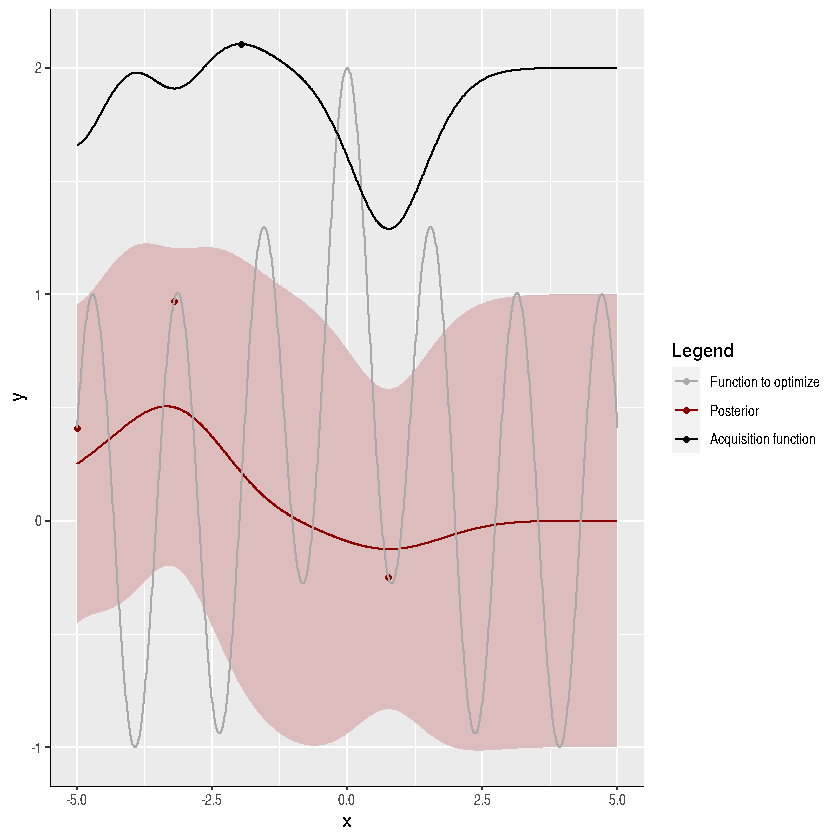

In [21]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [22]:
for (i in seq(20)) {
    y.n <- f(x.n)
    x.d <- c(x.d, x.n)
    y.d <- c(y.d, y.n)
    iter <- acquire(x.d, y.d, x.init)
    x.n <- iter$x.next
}

Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.023175 seconds (Sampling)
Chain 1:                0.023175 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021631 seconds (Sampling)
Chain 1:                0.021631 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.02286 seconds (Sampling)
Chain 1:                0.02286 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021656 seconds (Sampling)
Chain 1:                0.021656 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022161 seconds (Sampling)
Chain 1:                0.022161 seconds (Total)
Chain 1: 
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.022503 seconds (Sampling)
Chain 1:                0.022503 seconds (Total)
Chain 1: 
Chain 1: 
Ch

In [23]:
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

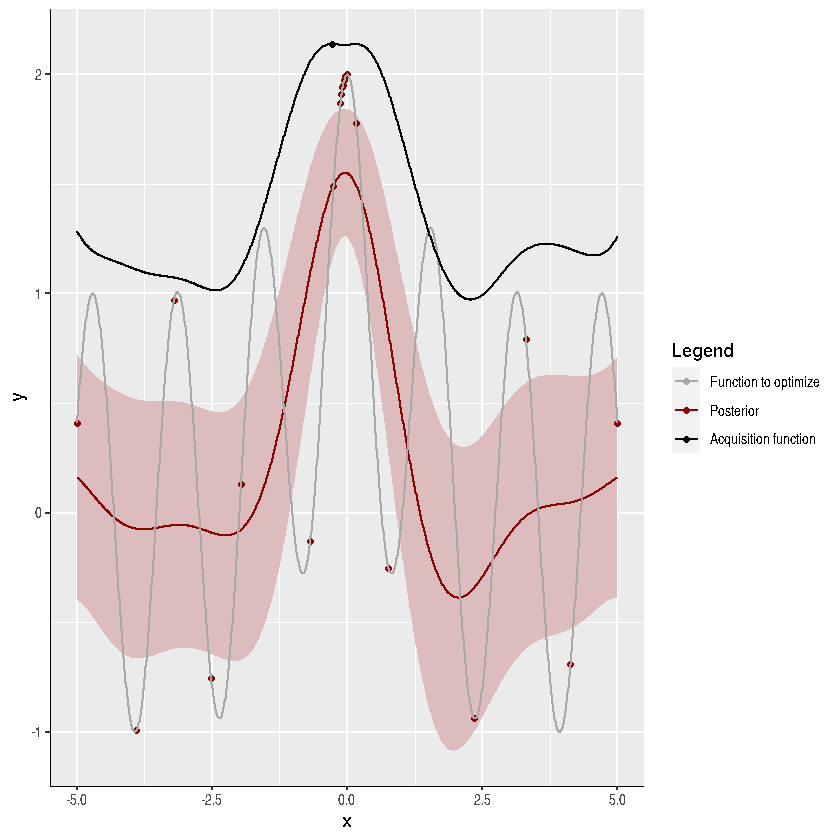

In [24]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))